<div style="text-align: center;">
  <h1 style="color: white; font-weight: bold; font-size: 2.5em; margin: 0.67em 0;">Diabetes Classification Notebook - Diabetes Dataset</h1>
</div>

### Overview

This project focuses on developing a machine learning model to predict diabetes (`Outcome`) using the Pima Indians Diabetes dataset, which contains 768 samples with 8 numerical features. The features are:

- `Pregnancies`: Number of times pregnant.
- `Glucose`: Plasma glucose concentration.
- `BloodPressure`: Diastolic blood pressure.
- `SkinThickness`: Triceps skin fold thickness.
- `Insulin`: 2-hour serum insulin.
- `BMI`: Body mass index.
- `DiabetesPedigreeFunction`: Diabetes pedigree function.
- `Age`: Age in years.

The goal is to compare Logistic Regression, SVM, Random Forest, and XGBoost to predict diabetes, using standardization, SMOTE, and hyperparameter tuning to optimize performance and evaluate results with accuracy, F1-score, and AUC-ROC.

---

# <span style="color:deepskyblue; font-weight:bold;">Importing Libraries</span>

In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2
from scipy.stats import kendalltau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE  # For SMOTE


# <span style="color:deepskyblue; font-weight:bold;">Loading and inspect dataset</span>

In [2]:
data = pd.read_csv('diabetes.csv')

In [3]:
data.shape

(768, 9)

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
# Columns where zero is not a valid measurement
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Count how many zeros in each
zero_counts = (data[invalid_zero_cols] == 0).sum()
print("Zeros count in selected columns:", zero_counts)

# Percentage of zeros
zero_percentages = ((data[invalid_zero_cols] == 0).sum() / len(data)) * 100
print("Zeros percentage in selected columns:", zero_percentages)

Zeros count in selected columns: Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64
Zeros percentage in selected columns: Glucose           0.651042
BloodPressure     4.557292
SkinThickness    29.557292
Insulin          48.697917
BMI               1.432292
dtype: float64


Nearly half of the Insulin values (48.7%) and about 30% of SkinThickness values are recorded as zero, which doesn't make biological sense - people should have measurable insulin and skin thickness. These are likely missing values that were coded as zeros instead of being properly marked as missing data.

In [9]:
data.duplicated().sum()

0

In [10]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

# <span style="color:deepskyblue; font-weight:bold;">Exploratory Data Analysis (EDA)</span>

In [11]:
print(data['Outcome'].value_counts(normalize=True) * 100)

Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


In [12]:
plt.style.use('default')
sns.set_palette("husl")

print("DATASET ANALYSIS")
print("="*60)
print("Dataset Info:")
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print("\nColumn Types:")
print(data.dtypes)
print("="*60)

if 'loan_id' in data.columns:
    data_clean = data.drop('loan_id', axis=1)
    print("Dropped 'loan_id' column")
else:
    data_clean = data.copy()
    print("No 'loan_id' column found, using all columns")

categorical_columns = []
numerical_columns = []

for col in data_clean.columns:
    if data_clean[col].dtype == 'object' or col=='Outcome':
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

print(f"\nAuto-detected columns:")
print(f"Categorical columns ({len(categorical_columns)}): {categorical_columns}")
print(f"Numerical columns ({len(numerical_columns)}): {numerical_columns}")
print("="*60)


DATASET ANALYSIS
Dataset Info:
Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Column Types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
No 'loan_id' column found, using all columns

Auto-detected columns:
Categorical columns (1): ['Outcome']
Numerical columns (8): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']



CATEGORICAL COLUMNS ANALYSIS
----------------------------------------


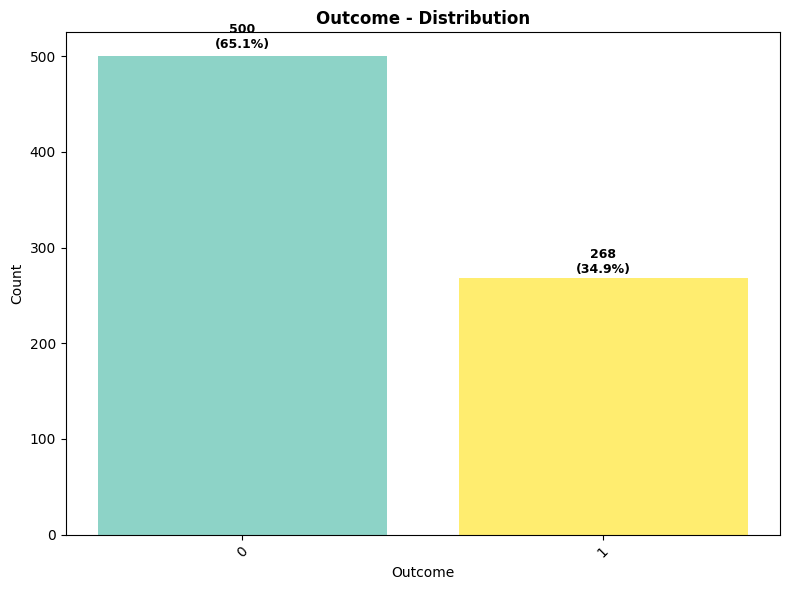

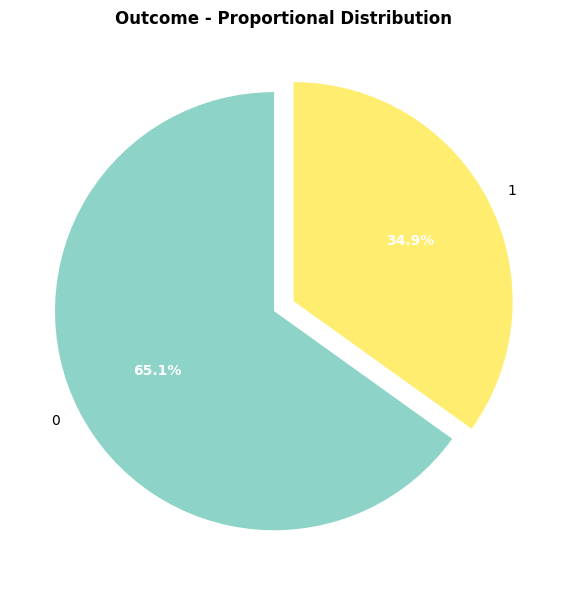


OUTCOME Summary:
  0: 500 (65.1%)
  1: 268 (34.9%)


In [13]:
print("\nCATEGORICAL COLUMNS ANALYSIS")
print("-" * 40)

if len(categorical_columns) > 0:
    for col in categorical_columns:
        # Bar Plot
        fig_bar, ax_bar = plt.subplots(figsize=(8, 6))
        value_counts = data[col].value_counts()
        bars = ax_bar.bar(range(len(value_counts)), value_counts.values, 
                         color=plt.cm.Set3(np.linspace(0, 1, len(value_counts))))
        ax_bar.set_title(f'{col.title().replace("_", " ")} - Distribution', 
                        fontweight='bold', fontsize=12)
        ax_bar.set_xlabel(col.title().replace("_", " "))
        ax_bar.set_ylabel('Count')
        ax_bar.set_xticks(range(len(value_counts)))
        ax_bar.set_xticklabels(value_counts.index, rotation=45)
        
        for bar, count in zip(bars, value_counts.values):
            height = bar.get_height()
            ax_bar.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{count}\n({count/len(data)*100:.1f}%)',
                       ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Pie Plot
        fig_pie, ax_pie = plt.subplots(figsize=(8, 6))
        colors = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))
        wedges, texts, autotexts = ax_pie.pie(value_counts.values, 
                                             labels=value_counts.index,
                                             autopct='%1.1f%%',
                                             colors=colors,
                                             startangle=90,
                                             explode=[0.05]*len(value_counts))
        ax_pie.set_title(f'{col.title().replace("_", " ")} - Proportional Distribution', 
                        fontweight='bold', fontsize=12)
        
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        
        plt.tight_layout()
        plt.show()
        
        # Summary
        print(f"\n{col.upper()} Summary:")
        percentages = (value_counts / len(data) * 100).round(2)
        for value, count, pct in zip(value_counts.index, value_counts.values, percentages):
            print(f"  {value}: {count} ({pct}%)")
else:
    print("No categorical columns found.")

The target variable is imbalanced with 65% non-diabetic and 35% diabetic cases, which will require techniques like SMOTE to ensure proper model training.



NUMERICAL COLUMNS ANALYSIS
----------------------------------------


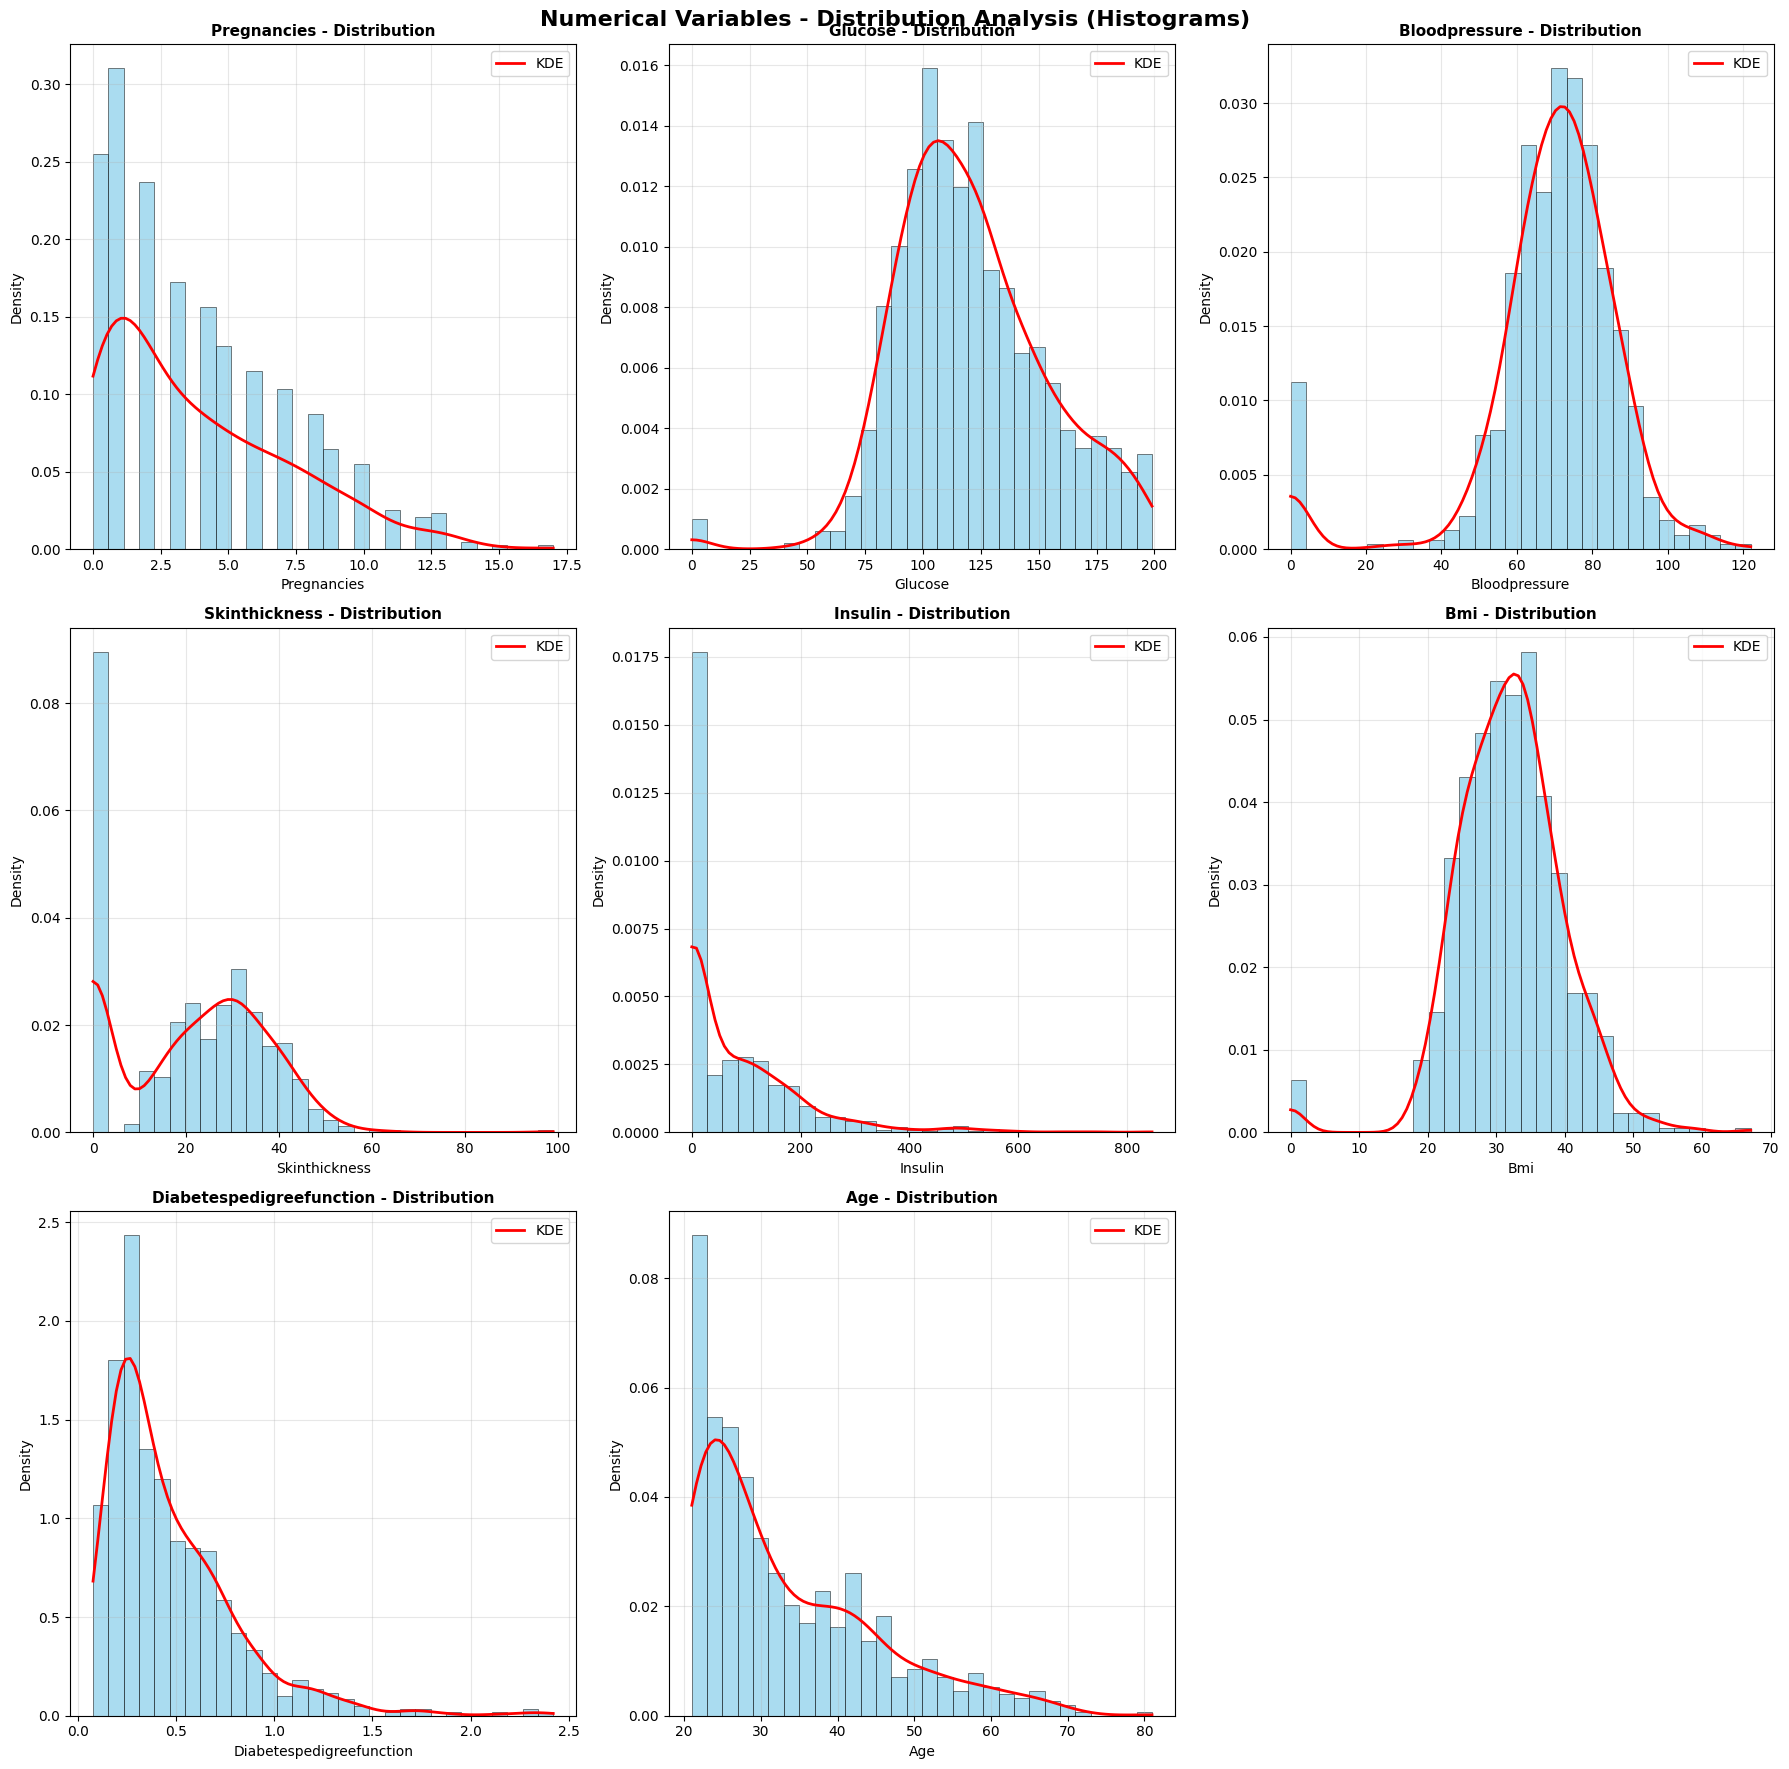

In [14]:
print("\n\nNUMERICAL COLUMNS ANALYSIS")
print("-" * 40)

n_num_cols = len(numerical_columns)
num_rows = (n_num_cols + 2) // 3
num_cols = 3

fig_hist, axes_hist = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows))
fig_hist.suptitle('Numerical Variables - Distribution Analysis (Histograms)', 
                    fontsize=16, fontweight='bold', y=0.98)

axes_hist = axes_hist.flatten() if n_num_cols > 1 else [axes_hist]

for i, col in enumerate(numerical_columns):
    if i < len(axes_hist):
        axes_hist[i].hist(data_clean[col], bins=30, alpha=0.7, color='skyblue', 
                            density=True, edgecolor='black', linewidth=0.5)
        
        try:
            kde_x = np.linspace(data_clean[col].min(), data_clean[col].max(), 100)
            kde = stats.gaussian_kde(data_clean[col])
            axes_hist[i].plot(kde_x, kde(kde_x), color='red', linewidth=2, label='KDE')
        except:
            pass
        
        axes_hist[i].set_title(f'{col.title().replace("_", " ")} - Distribution', 
                                fontweight='bold', fontsize=11)
        axes_hist[i].set_xlabel(col.title().replace("_", " "))
        axes_hist[i].set_ylabel('Density')
        axes_hist[i].grid(True, alpha=0.3)
        axes_hist[i].legend()

for i in range(n_num_cols, len(axes_hist)):
    axes_hist[i].set_visible(False)

plt.tight_layout()
plt.show()


Numerical Distribution:
The histograms reveal mixed distribution patterns across features. Glucose, BloodPressure, and BMI show relatively normal distributions, while Pregnancies and Age are right-skewed with most values concentrated at lower ranges. SkinThickness and Insulin show problematic distributions dominated by zero values, confirming our earlier data quality concerns.

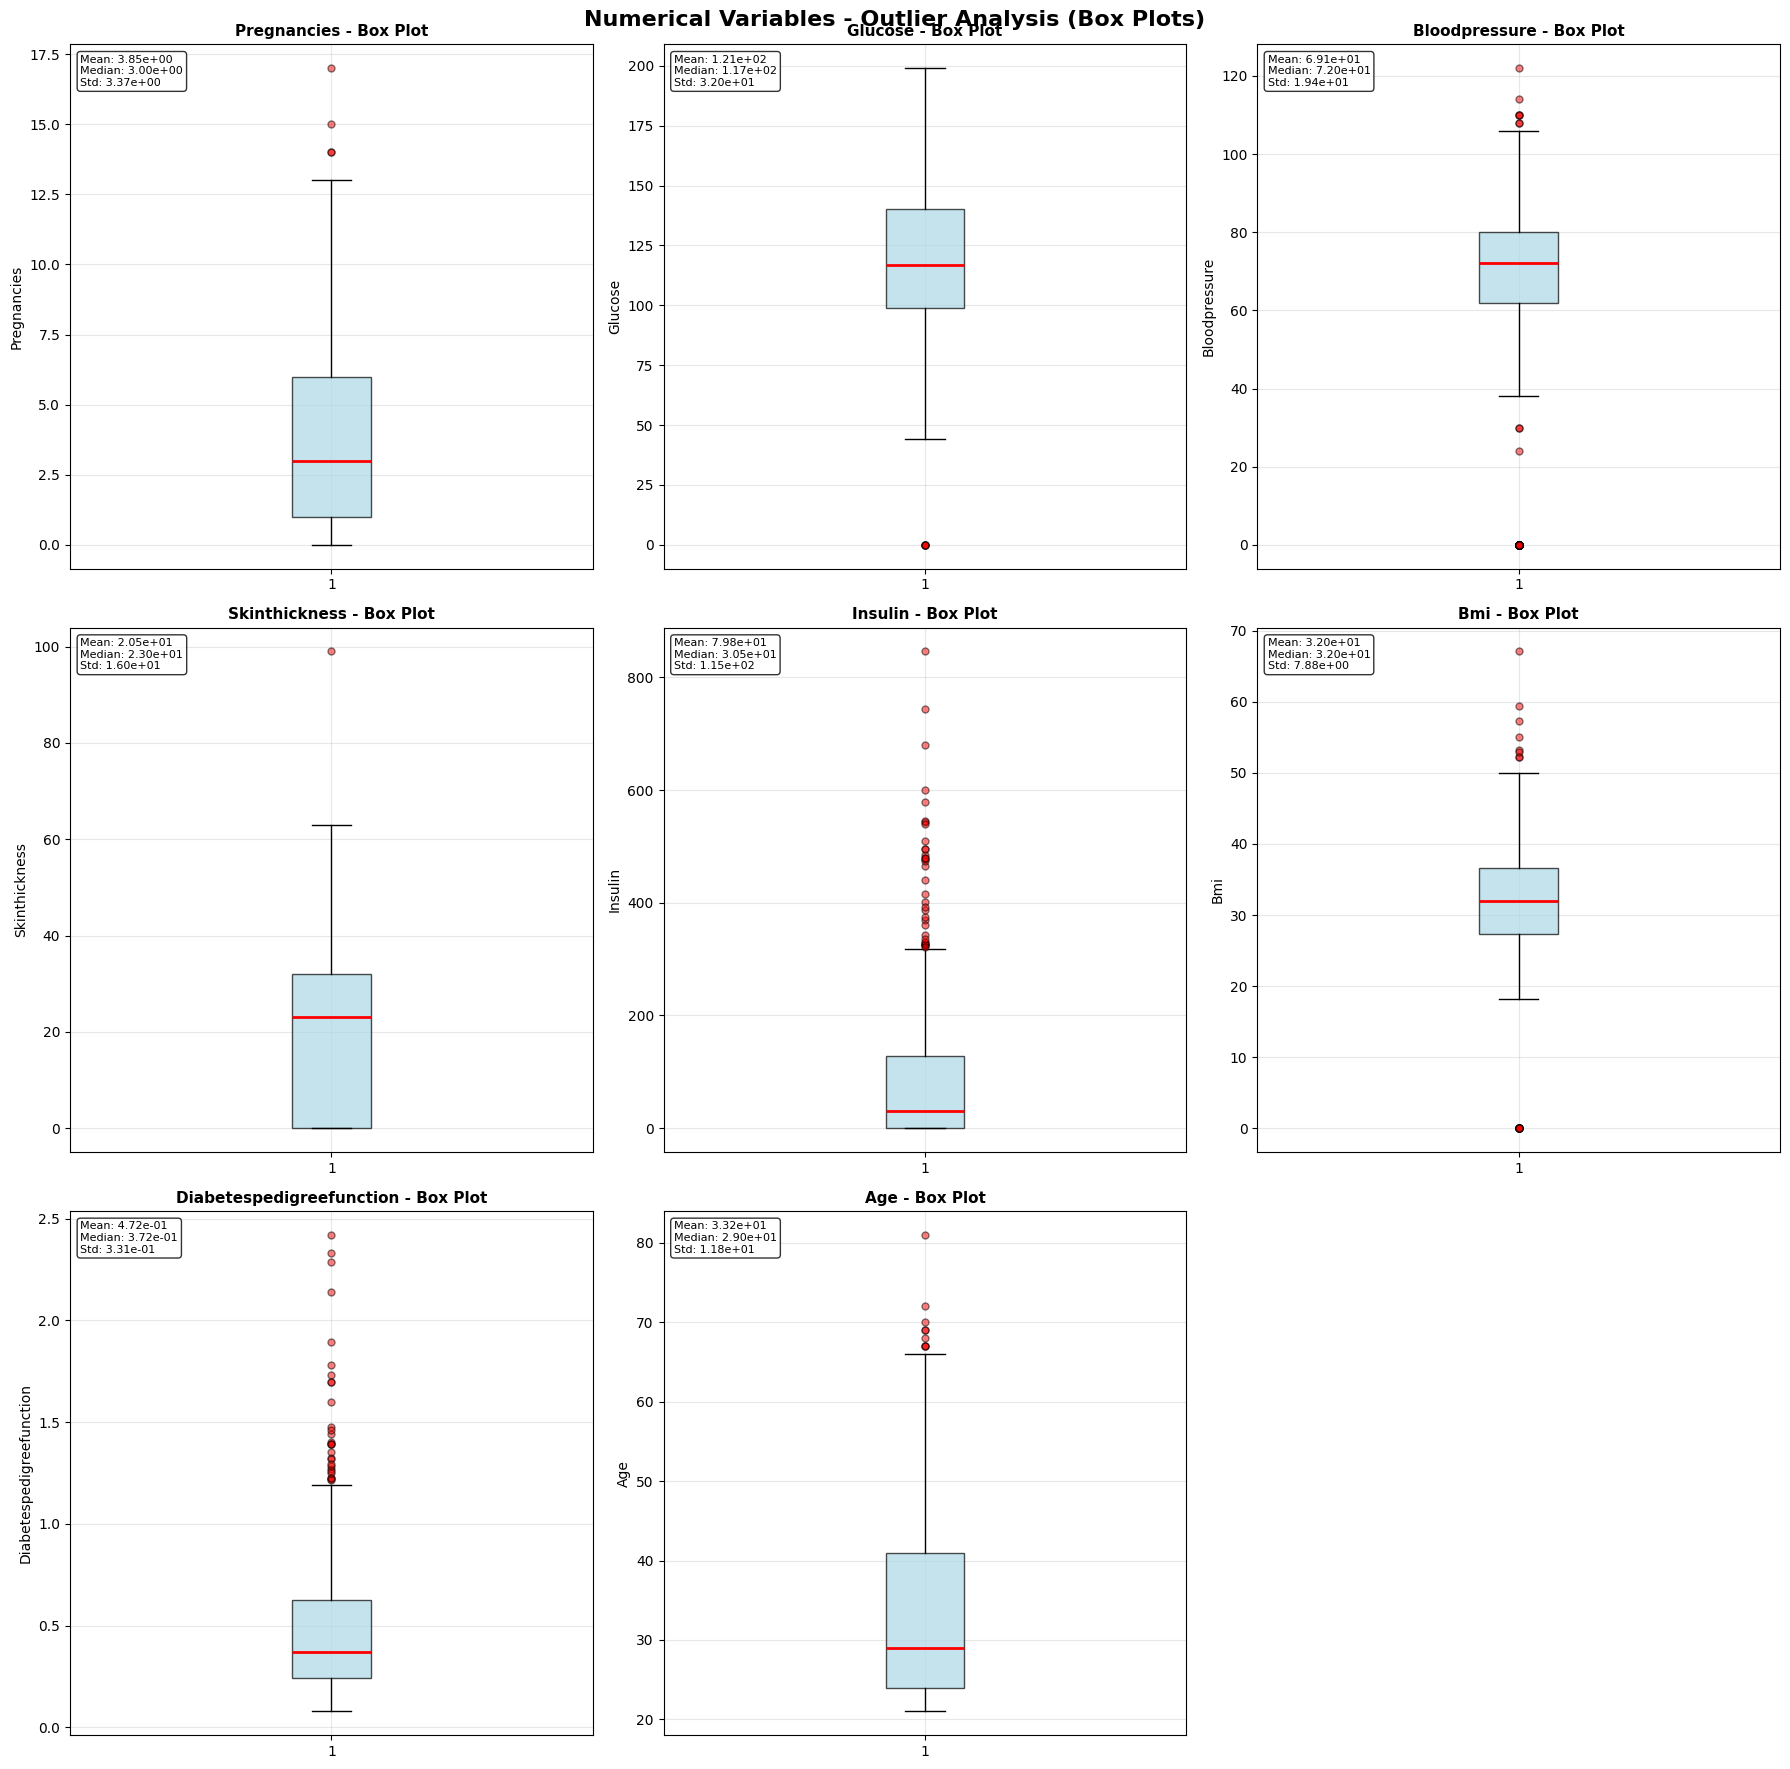


Numerical Variables Summary Statistics:
          Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
count        7.68e+02 7.68e+02       7.68e+02       7.68e+02 7.68e+02   
mean         3.85e+00 1.21e+02       6.91e+01       2.05e+01 7.98e+01   
std          3.37e+00 3.20e+01       1.94e+01       1.60e+01 1.15e+02   
min          0.00e+00 0.00e+00       0.00e+00       0.00e+00 0.00e+00   
25%          1.00e+00 9.90e+01       6.20e+01       0.00e+00 0.00e+00   
50%          3.00e+00 1.17e+02       7.20e+01       2.30e+01 3.05e+01   
75%          6.00e+00 1.40e+02       8.00e+01       3.20e+01 1.27e+02   
max          1.70e+01 1.99e+02       1.22e+02       9.90e+01 8.46e+02   
skewness     9.00e-01 1.73e-01      -1.84e+00       1.09e-01 2.27e+00   
kurtosis     1.50e-01 6.29e-01       5.14e+00      -5.24e-01 7.16e+00   

               BMI  DiabetesPedigreeFunction      Age  
count     7.68e+02                  7.68e+02 7.68e+02  
mean      3.20e+01                  4.72e-0

In [15]:

fig_box, axes_box = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows))
fig_box.suptitle('Numerical Variables - Outlier Analysis (Box Plots)', 
                    fontsize=16, fontweight='bold', y=0.98)

axes_box = axes_box.flatten() if n_num_cols > 1 else [axes_box]

for i, col in enumerate(numerical_columns):
    if i < len(axes_box):
        box_plot = axes_box[i].boxplot(data_clean[col], patch_artist=True, 
                                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                                        medianprops=dict(color='red', linewidth=2),
                                        flierprops=dict(marker='o', markerfacecolor='red', 
                                                    markersize=5, alpha=0.5))
        
        axes_box[i].set_title(f'{col.title().replace("_", " ")} - Box Plot', 
                                fontweight='bold', fontsize=11)
        axes_box[i].set_ylabel(col.title().replace("_", " "))
        axes_box[i].grid(True, alpha=0.3)
        
        q1, median, q3 = np.percentile(data_clean[col], [25, 50, 75])
        mean_val = data_clean[col].mean()
        std_val = data_clean[col].std()
        
        stats_text = f'Mean: {mean_val:.2e}\nMedian: {median:.2e}\nStd: {std_val:.2e}'
        axes_box[i].text(0.02, 0.98, stats_text, transform=axes_box[i].transAxes,
                        verticalalignment='top', bbox=dict(boxstyle='round', 
                        facecolor='white', alpha=0.8), fontsize=8)

for i in range(n_num_cols, len(axes_box)):
    axes_box[i].set_visible(False)

plt.tight_layout()
plt.show()

print("\nNumerical Variables Summary Statistics:")
print("=" * 80)

summary_stats = data_clean[numerical_columns].describe()

additional_stats = pd.DataFrame(index=['skewness', 'kurtosis'])
for col in numerical_columns:
    additional_stats.loc['skewness', col] = stats.skew(data_clean[col])
    additional_stats.loc['kurtosis', col] = stats.kurtosis(data_clean[col])

full_summary = pd.concat([summary_stats, additional_stats])

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2e}'.format)

print(full_summary)

pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.float_format')


Box Plot:
The box plots highlight significant outliers, particularly in Insulin and SkinThickness where extreme values exist beyond the normal ranges. Pregnancies shows several high outliers (up to 17), while Age and BMI have moderate outliers. The presence of many zeros in Insulin and SkinThickness is clearly visible as the lower quartile sits at zero.



CORRELATION ANALYSIS
----------------------------------------


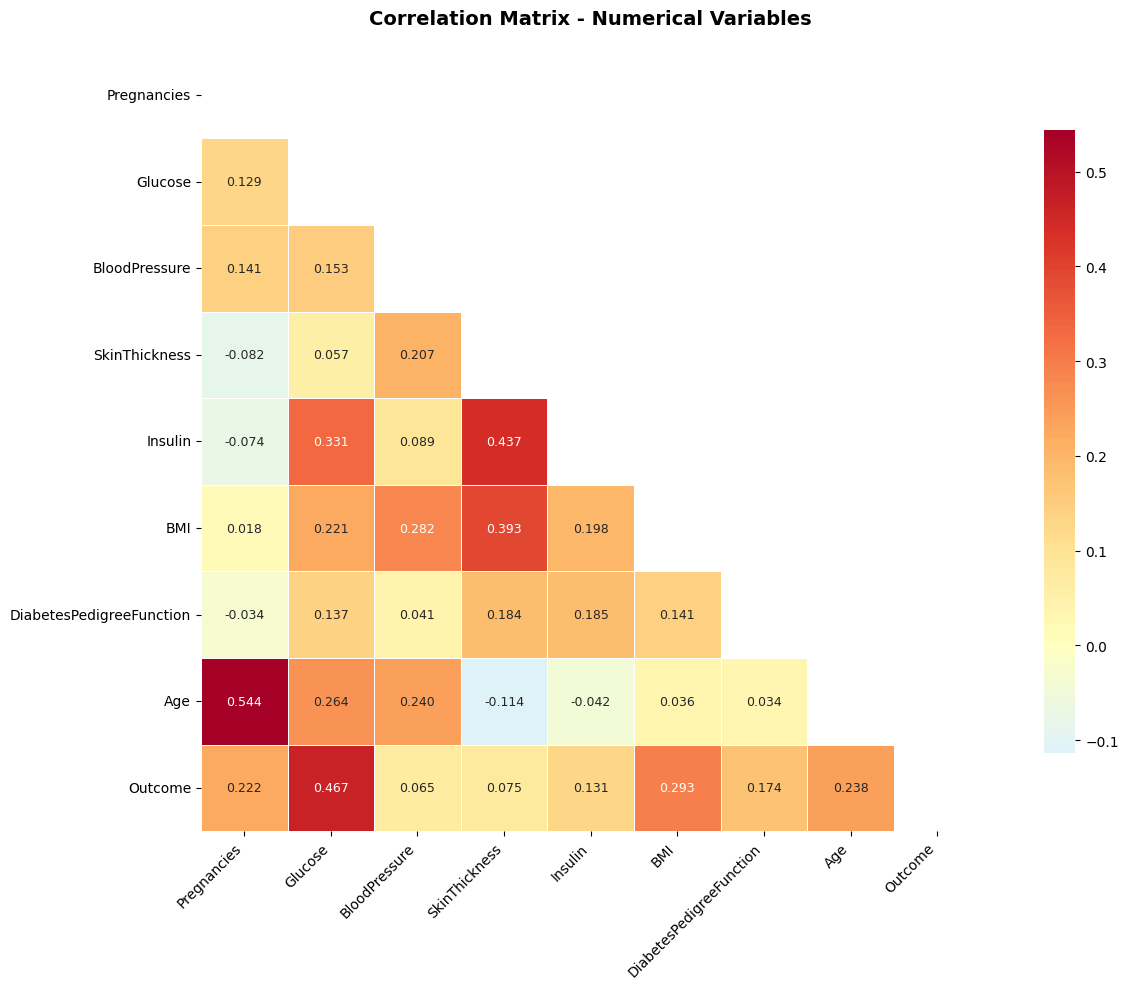

Highly Correlated Variable Pairs (|correlation| > 0.7):
  No highly correlated pairs found (threshold: |correlation| > 0.7)


In [16]:

if len(numerical_columns) > 1:
    print("\n\nCORRELATION ANALYSIS")
    print("-" * 40)
    numerical_columns.append('Outcome')
    correlation_matrix = data_clean[numerical_columns].corr()
    
    plt.figure(figsize=(14, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
                            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8},
                            fmt='.3f', annot_kws={'size': 9})
    plt.title('Correlation Matrix - Numerical Variables', fontweight='bold', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("Highly Correlated Variable Pairs (|correlation| > 0.7):")
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((correlation_matrix.columns[i], 
                                        correlation_matrix.columns[j], 
                                        corr_val))
    
    if high_corr_pairs:
        for var1, var2, corr in high_corr_pairs:
            print(f"  {var1} ↔ {var2}: {corr:.3f}")
    else:
        print("  No highly correlated pairs found (threshold: |correlation| > 0.7)")

Correlation Heatmap:
Glucose shows the strongest correlation with diabetes outcome (0.467), followed by BMI (0.293) and Age (0.238), making these key predictive features. Moderate inter-feature correlations exist between Age-Pregnancies (0.544) and Insulin-SkinThickness (0.437), suggesting some multicollinearity that models will need to handle.

In [17]:
# Separate features (all columns except 'Outcome') and target
features = data.drop(columns=['Outcome'])  # Features to standardize
target = data['Outcome']  

scaler = StandardScaler()

standardized_features = scaler.fit_transform(features)
standardized_data = pd.DataFrame(standardized_features, columns=features.columns)

data = pd.concat([standardized_data, target.reset_index(drop=True)], axis=1)

print(data.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.848324       0.149641       0.907270 -0.692891  0.204013   
1    -0.844885 -1.123396      -0.160546       0.530902 -0.692891 -0.684422   
2     1.233880  1.943724      -0.263941      -1.288212 -0.692891 -1.103255   
3    -0.844885 -0.998208      -0.160546       0.154533  0.123302 -0.494043   
4    -1.141852  0.504055      -1.504687       0.907270  0.765836  1.409746   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.468492  1.425995        1  
1                 -0.365061 -0.190672        0  
2                  0.604397 -0.105584        1  
3                 -0.920763 -1.041549        0  
4                  5.484909 -0.020496        1  


# <span style="color:deepskyblue; font-weight:bold;">Model Building</span>

In [18]:
X = data.drop(columns=['Outcome'])
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verify class distribution after SMOTE
print("Class distribution before SMOTE:", dict(pd.Series(y_train).value_counts()))
print("Class distribution after SMOTE:", dict(pd.Series(y_train_smote).value_counts()))

# Data structure to store results for later comparison
model_results = {}

# Helper function to evaluate and plot for a model
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Scores for train
    train_acc = accuracy_score(y_train, y_train_pred)
    train_prec = precision_score(y_train, y_train_pred)
    train_rec = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    
    # Scores for test
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # Store results
    results = {
        'train': {'accuracy': train_acc, 'precision': train_prec, 'recall': train_rec, 'f1': train_f1, 'auc': train_auc},
        'test': {'accuracy': test_acc, 'precision': test_prec, 'recall': test_rec, 'f1': test_f1, 'auc': test_auc}
    }
    model_results[model_name] = results
    
    # Print stats
    print(f"\n=== {model_name} Results (with SMOTE) ===")
    print("Train Scores:")
    print(f" Accuracy: {train_acc:.4f}")
    print(f" Precision: {train_prec:.4f}")
    print(f" Recall: {train_rec:.4f}")
    print(f" F1-Score: {train_f1:.4f}")
    print(f" AUC-ROC: {train_auc:.4f}")
    print("\nTest Scores:")
    print(f" Accuracy: {test_acc:.4f}")
    print(f" Precision: {test_prec:.4f}")
    print(f" Recall: {test_rec:.4f}")
    print(f" F1-Score: {test_f1:.4f}")
    print(f" AUC-ROC: {test_auc:.4f}")
    
    # Gaps (for overfitting analysis: positive gap indicates potential overfitting)
    acc_gap = train_acc - test_acc
    prec_gap = train_prec - test_prec
    rec_gap = train_rec - test_rec
    f1_gap = train_f1 - test_f1
    auc_gap = train_auc - test_auc
    print(f"\nOverfitting Gaps (Train - Test):")
    print(f" Accuracy Gap: {acc_gap:.4f}")
    print(f" Precision Gap: {prec_gap:.4f}")
    print(f" Recall Gap: {rec_gap:.4f}")
    print(f" F1-Score Gap: {f1_gap:.4f}")
    print(f" AUC-ROC Gap: {auc_gap:.4f}")
    if acc_gap > 0.1:
        print(" Note: High accuracy gap (>0.1) suggests potential overfitting.")
    else:
        print(" Note: Low gap indicates good generalization.")
    
    # Plot Confusion Matrix for Test Set
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix (Test Set, with SMOTE)')
    plt.show()

Class distribution before SMOTE: {0: 400, 1: 214}
Class distribution after SMOTE: {0: 400, 1: 400}


# <span style="color:deepskyblue; font-weight:bold;">Model Evaluation</span>

Training Logistic Regression with SMOTE...

=== Logistic Regression Results (with SMOTE) ===
Train Scores:
 Accuracy: 0.7575
 Precision: 0.7641
 Recall: 0.7450
 F1-Score: 0.7544
 AUC-ROC: 0.8391

Test Scores:
 Accuracy: 0.7338
 Precision: 0.5942
 Recall: 0.7593
 F1-Score: 0.6667
 AUC-ROC: 0.8137

Overfitting Gaps (Train - Test):
 Accuracy Gap: 0.0237
 Precision Gap: 0.1699
 Recall Gap: -0.0143
 F1-Score Gap: 0.0878
 AUC-ROC Gap: 0.0254
 Note: Low gap indicates good generalization.


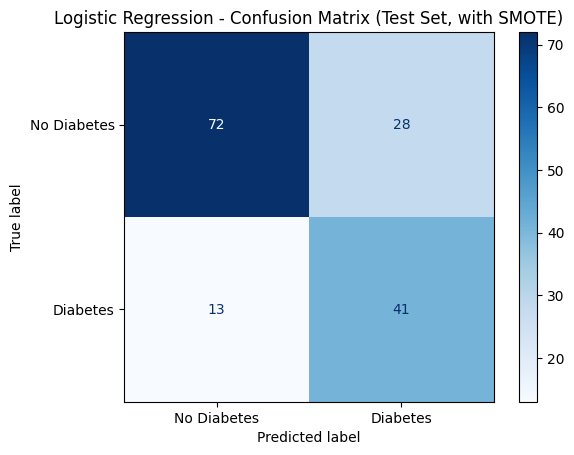

In [19]:
# Model 1: Logistic Regression with expanded GridSearchCV for tuning
print("Training Logistic Regression with SMOTE...")
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}  # Expanded grid
lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid_lr, cv=5, scoring='f1')
evaluate_model(lr, 'Logistic Regression', X_train_smote, y_train_smote, X_test, y_test)


Training SVM with SMOTE...

=== SVM Results (with SMOTE) ===
Train Scores:
 Accuracy: 0.9000
 Precision: 0.8687
 Recall: 0.9425
 F1-Score: 0.9041
 AUC-ROC: 0.9617

Test Scores:
 Accuracy: 0.6948
 Precision: 0.5574
 Recall: 0.6296
 F1-Score: 0.5913
 AUC-ROC: 0.7774

Overfitting Gaps (Train - Test):
 Accuracy Gap: 0.2052
 Precision Gap: 0.3113
 Recall Gap: 0.3129
 F1-Score Gap: 0.3128
 AUC-ROC Gap: 0.1843
 Note: High accuracy gap (>0.1) suggests potential overfitting.


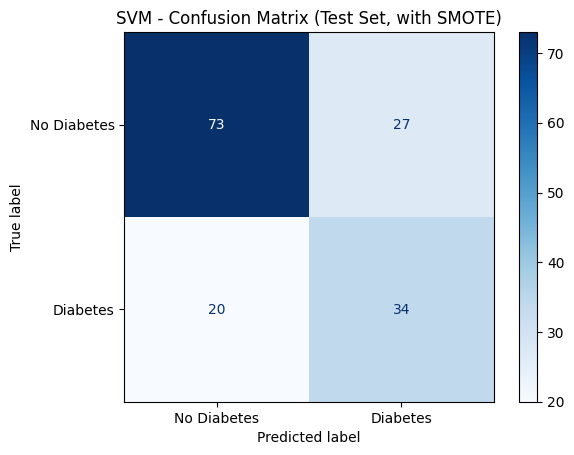

In [20]:
# Model 2: SVM with expanded GridSearchCV for tuning
print("\nTraining SVM with SMOTE...")
param_grid_svm = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}  # Expanded grid
svm = GridSearchCV(SVC(random_state=42, probability=True), param_grid_svm, cv=5, scoring='f1')
evaluate_model(svm, 'SVM', X_train_smote, y_train_smote, X_test, y_test)


Training Random Forest with SMOTE...

=== Random Forest Results (with SMOTE) ===
Train Scores:
 Accuracy: 0.7925
 Precision: 0.7955
 Recall: 0.7875
 F1-Score: 0.7915
 AUC-ROC: 0.8850

Test Scores:
 Accuracy: 0.7338
 Precision: 0.5970
 Recall: 0.7407
 F1-Score: 0.6612
 AUC-ROC: 0.8133

Overfitting Gaps (Train - Test):
 Accuracy Gap: 0.0587
 Precision Gap: 0.1984
 Recall Gap: 0.0468
 F1-Score Gap: 0.1303
 AUC-ROC Gap: 0.0717
 Note: Low gap indicates good generalization.


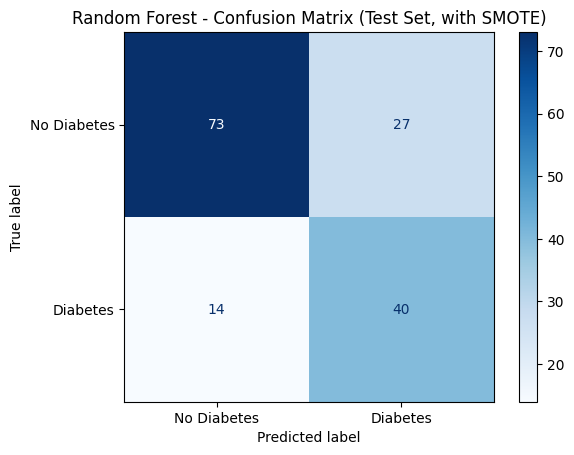

In [21]:
# Model 3: Random Forest with expanded GridSearchCV (adjusted for overfitting)
print("\nTraining Random Forest with SMOTE...")
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [2, 3], 'min_samples_split': [5, 10], 'min_samples_leaf': [1, 2], 'max_features': ['sqrt', 0.5]}  # Updated grid
rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1')
evaluate_model(rf, 'Random Forest', X_train_smote, y_train_smote, X_test, y_test)



Training XGBoost with SMOTE...

=== XGBoost Results (with SMOTE) ===
Train Scores:
 Accuracy: 0.8662
 Precision: 0.8415
 Recall: 0.9025
 F1-Score: 0.8709
 AUC-ROC: 0.9369

Test Scores:
 Accuracy: 0.7727
 Precision: 0.6377
 Recall: 0.8148
 F1-Score: 0.7154
 AUC-ROC: 0.8343

Overfitting Gaps (Train - Test):
 Accuracy Gap: 0.0935
 Precision Gap: 0.2038
 Recall Gap: 0.0877
 F1-Score Gap: 0.1555
 AUC-ROC Gap: 0.1026
 Note: Low gap indicates good generalization.


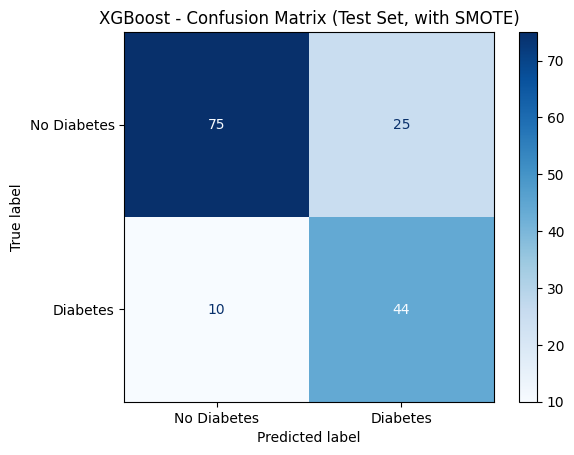

In [22]:

# Model 4: XGBoost with expanded GridSearchCV (adjusted for overfitting)
print("\nTraining XGBoost with SMOTE...")
param_grid_xgb = {'n_estimators': [50, 100], 'max_depth': [2, 3], 'learning_rate': [0.01, 0.05], 'min_child_weight': [1, 2], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}  # Updated grid
xgb_model = GridSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='logloss'), param_grid_xgb, cv=5, scoring='f1')
evaluate_model(xgb_model, 'XGBoost', X_train_smote, y_train_smote, X_test, y_test)


Model Comparison Summary (with SMOTE and Tuning):
                     Train Accuracy  Test Accuracy  Train F1   Test F1  \
Logistic Regression         0.75750       0.733766  0.754430  0.666667   
SVM                         0.90000       0.694805  0.904077  0.591304   
Random Forest               0.79250       0.733766  0.791457  0.661157   
XGBoost                     0.86625       0.772727  0.870929  0.715447   

                     Train AUC  Test AUC   Acc Gap    F1 Gap   AUC Gap  
Logistic Regression   0.839081  0.813704  0.023734  0.087764  0.025378  
SVM                   0.961663  0.777407  0.205195  0.312772  0.184255  
Random Forest         0.885012  0.813333  0.058734  0.130300  0.071679  
XGBoost               0.936906  0.834259  0.093523  0.155482  0.102647  


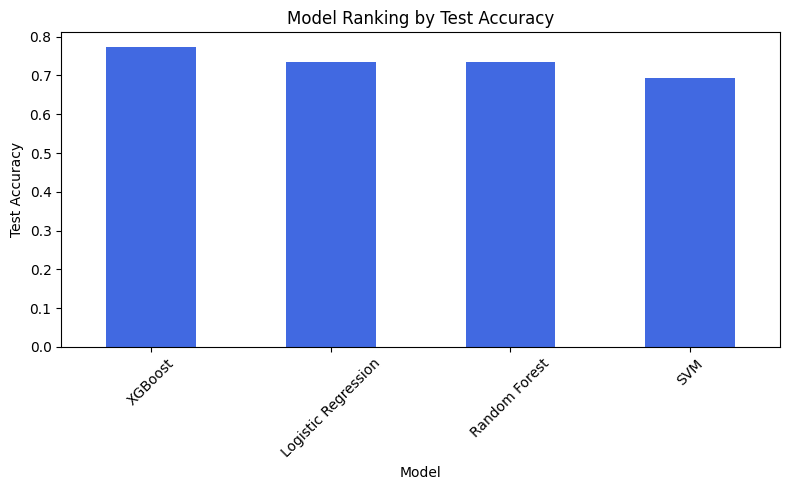

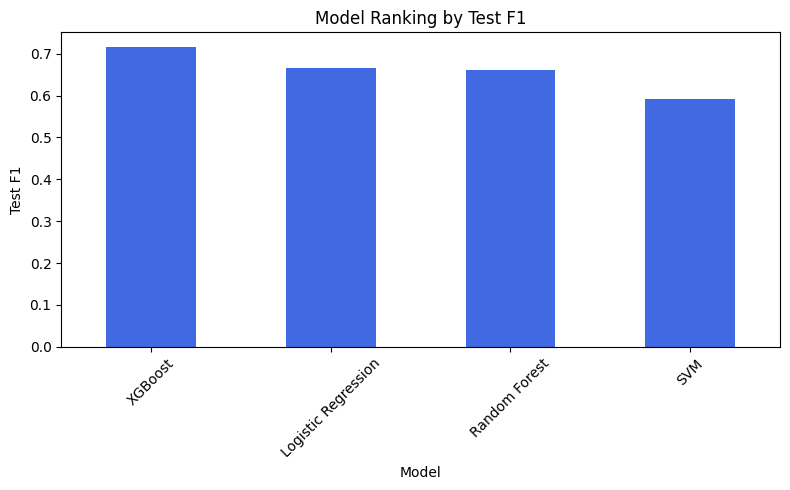

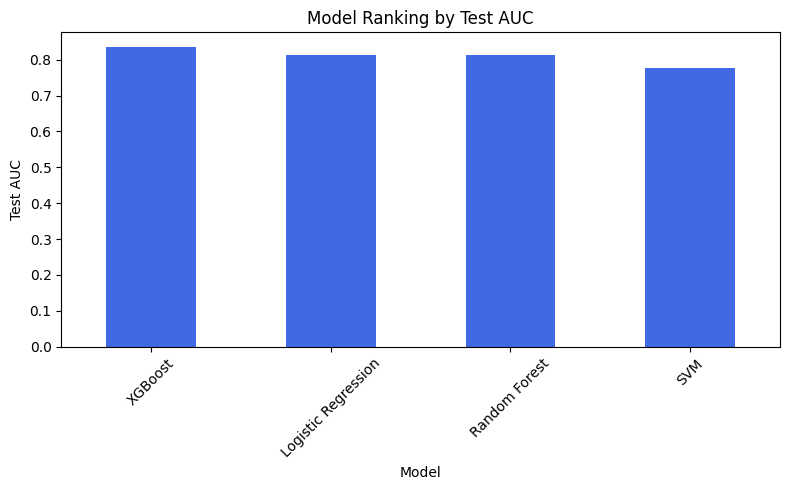

In [ ]:

# Create comparison DataFrame for later use
comparison_df = pd.DataFrame({
    model_name: {
        'Train Accuracy': results['train']['accuracy'],
        'Test Accuracy': results['test']['accuracy'],
        'Train F1': results['train']['f1'],
        'Test F1': results['test']['f1'],
        'Train AUC': results['train']['auc'],
        'Test AUC': results['test']['auc'],
        'Acc Gap': results['train']['accuracy'] - results['test']['accuracy'],
        'F1 Gap': results['train']['f1'] - results['test']['f1'],
        'AUC Gap': results['train']['auc'] - results['test']['auc']
    } for model_name, results in model_results.items()
}).T
print("\nModel Comparison Summary (with SMOTE and Tuning):")
print(comparison_df)


# Simple bar plots for model ranking on test set metrics
metrics = ['Test Accuracy', 'Test F1', 'Test AUC']
for metric in metrics:
    plt.figure(figsize=(8, 5))
    comparison_df[metric].sort_values(ascending=False).plot(kind='bar', color='royalblue')
    plt.title(f'Model Ranking by {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# <font color='royaleblue'> <b>Conclusion</b><font color='orange'>  

The project successfully compared four machine learning models for diabetes prediction using standardization and SMOTE to enhance performance. **Standardization** ensured fair contribution across features with different scales, while **SMOTE** balanced the dataset by generating synthetic minority samples, improving detection of diabetes cases.

**XGBoost** emerged as the best model with Test Accuracy of 0.7727, F1 of 0.7154, and AUC of 0.8343. Despite moderate overfitting (gaps of 0.0935, 0.1555, and 0.1026 respectively), it showed strong generalization and class discrimination. SVM exhibited the highest overfitting (Acc Gap = 0.2052), suggesting the need for additional regularization. Future work should focus on reducing overfitting through techniques like early stopping or hyperparameter adjustment to optimize real-world deployment.